# ==============================================================
# MoE Post-Hoc Analysis Notebook for MoE-MAE
# ==============================================================

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from models.moe_mae import MOEMAE, build_model
from datasets.bigearthnet import BigEarthNetDatasetLS
from utils.data_config import BigEarthNetInfo
from transformation.transformer import ToFloat, CenterCrop40, ZScoreNormalize
from utils.data_utils import load_model
from utils.analysis_utils import layer_report_simple

In [2]:
data_csv = "./sample_dataset/samples.csv"
data_path = "./sample_dataset"

In [3]:
device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
print(f"Using device: {device}")

Using device: mps


In [4]:
model_size = "S"
img_size = 40
patch_size = 4
in_channels = 7
checkpoint_path = "./weights/moe_mae_bigearthnet_ls/pretrained_S_best.pth"
encoder = build_model(
        size=model_size,
        img_size=img_size,
        patch_size=patch_size,
        in_chans=in_channels,
    )
model = MOEMAE(encoder).to(device)
model = load_model(model,checkpoint_path,device)
encoder = model.encoder
encoder.eval();

In [5]:
bigearth_transforms = transforms.Compose(
        [
            ToFloat(),
            CenterCrop40(),
            ZScoreNormalize(
                BigEarthNetInfo.STATISTICS["mean"],
                BigEarthNetInfo.STATISTICS["std"],
            ),
        ]
    )
dataset = BigEarthNetDatasetLS(
        data_csv,
        data_path,
        transform=bigearth_transforms,
        supervised=False,
    )

dataloader = DataLoader(
        dataset,
        batch_size=16,
        persistent_workers=False,
        num_workers=2,
        shuffle=False,
        pin_memory=True,
    )

In [6]:
data_iter = iter(dataloader)

/Users/syam/virtualenvs/myvenv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [10]:
imgs, labels, meta_week, meta_hour, meta_lat, meta_lon = next(data_iter)

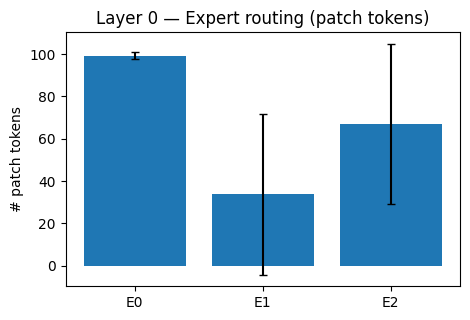

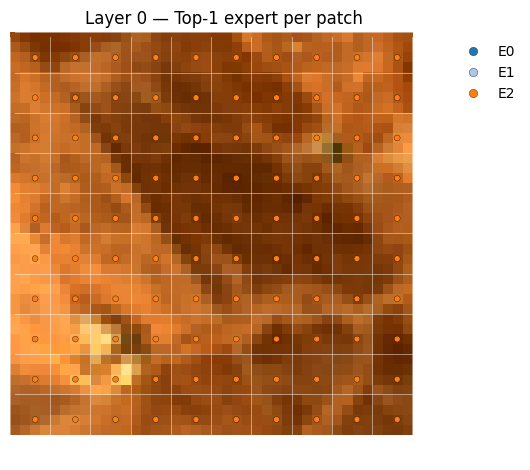

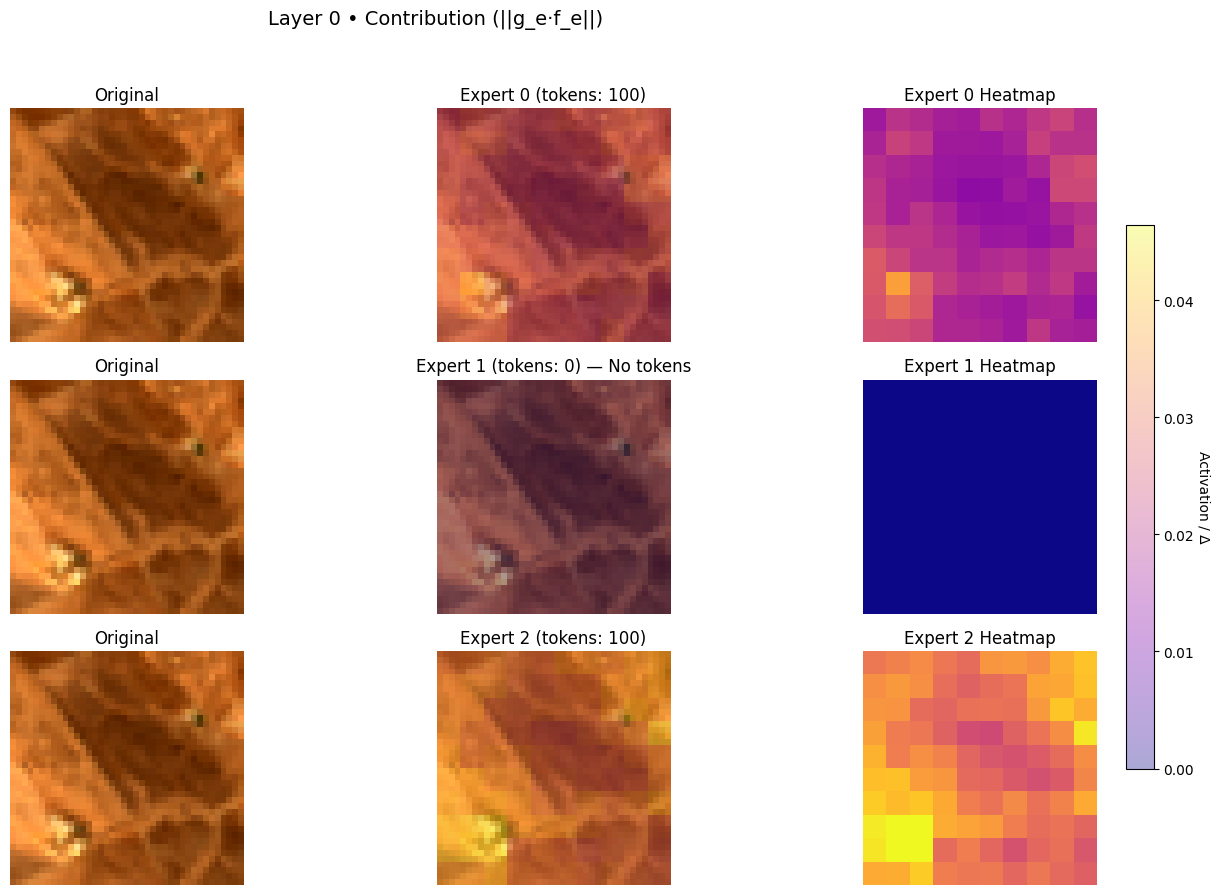

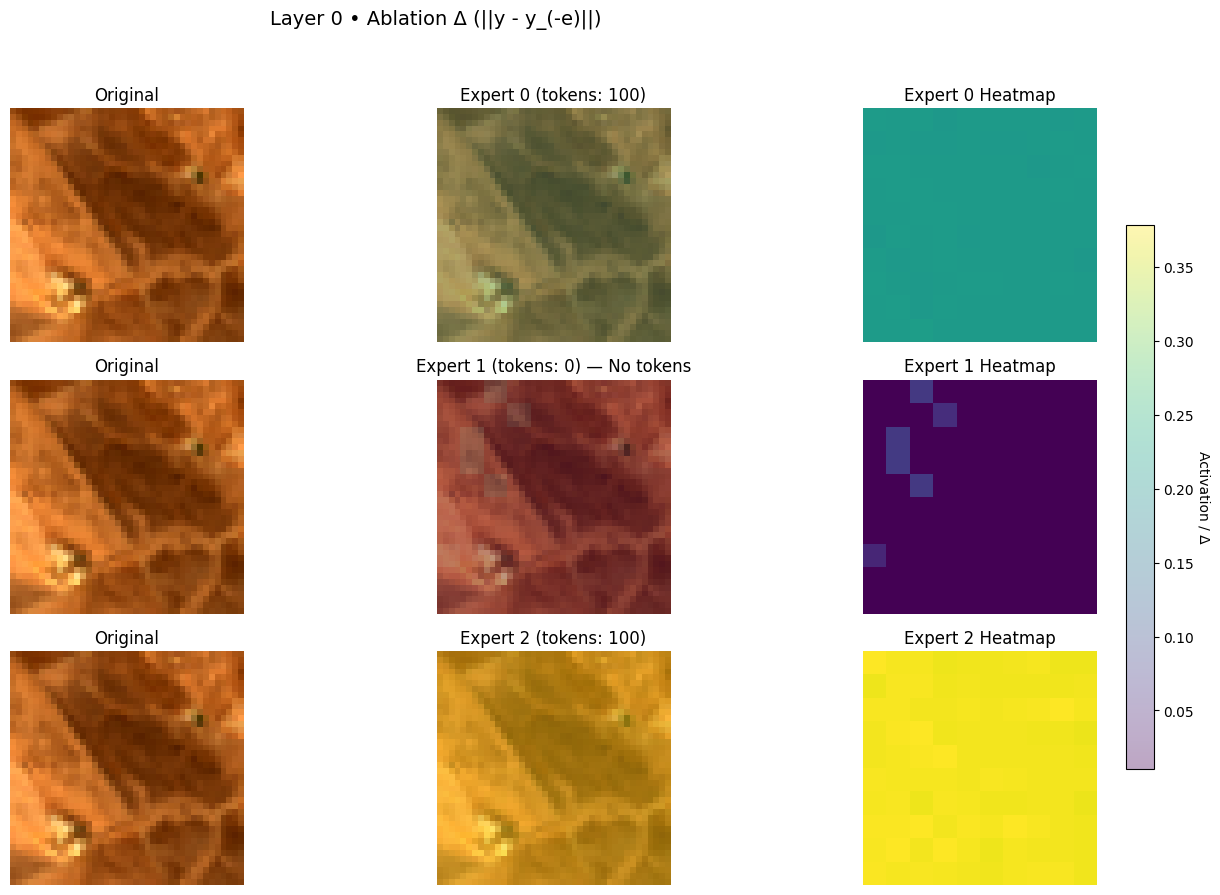

{'num_experts': 3,
 'usage_image': array([100,   0, 100]),
 'moe_loss': 0.03590909019112587}

In [11]:
# Pick an image and a layer to inspect
image_index = 0
layer_index = 0 
layer_report_simple(
    model,
    imgs,
    meta_week=meta_week, meta_hour=meta_hour, meta_lat=meta_lat, meta_lon=meta_lon,
    image_index=image_index,
    layer_index=layer_index,
    max_values=np.array([65454.0, 65454.0, 65330.308]), # From BigEartInfo STATS
    rgb_bands=(3,2,1),
    device=device
)